# Optimizing a Faust


When a Faust object is instantiated it might be possible to optimize its structure or configuration before using it elsewhere. It applies in all cases, whether you gave explicitly the matrices to define the Faust or you obtained it through a FAµST algorithm or an operation like Faust-slicing.
Indeed, several operations are available in the FAµST API to optimize a Faust object, in memory space or in computation time.  

In this notebook, we'll present three functions that aim at fulfilling these tasks:

[1. Faust.optimize_memory](#1.-Faust.optimize_memory)  
[2. Faust.optimize_time](#2.-Faust.optimize_time)  
[3. Faust.pruneout](#3.-Faust.pruneout)  

## 1. Faust.optimize_memory

As you probably already know, a Faust can be composed of dense or sparse factors. In the FAµST C++ core, a dense matrix is encoded as a column-major order array in memory while a sparse matrix follows the [CSR format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html). Although this is not memory efficient, it is totally possible to encode a sparse matrix in the dense format and conversely a dense matrix in the CSR format. There is no reason to do this but in many situations you might end up with a Faust encoded in a non-optimal format in your code.   
That's where the ``Faust.optimize_memory`` function comes up, it takes a Faust and gives you back a new one for which the format of each factor is ensured to be memory efficient. It means that depending on the number of nonzeros of the considered matrix, the format will be chosen by the function to minimize the memory used for the whole Faust.

Let's show this principle with a very simple example:

we build a Faust creating my own CSR matrix using [scipy](https://www.scipy.org/) and a dense matrix using a [numpy](https://numpy.org/) array. On purpose we choose to create a CSR matrix of size NxN whose nnz is equal to N^2 (something that obviously must be encoded as a numpy array) and likewise we create a numpy array of size NxN whose nnz is 1 (here again the format is not well chosen because a CSR matrix would be far lighter in memory).

In [ ]:
import numpy as np
import pyfaust as pf
from scipy.sparse import random

N = 64
S = random(N, N, 1, format='csr') # density = 1 <=> nnz = N^2
M = np.zeros((N,N))
M[0,0] = 1
# now create the Faust
F = pf.Faust([S, M]) # S is in CSR format, M is in column-major order array

Let's check the size (in bytes) of the Faust F we've just created.

In [ ]:
F.nbytes

Now use the ``optimize_memory`` function to get a memory-efficient Faust equal to F and check its new size.


In [ ]:
G = F.optimize_memory()
G.nbytes

Let us verify that F and G are really equal.

In [ ]:
np.allclose(F.toarray(), G.toarray())

As you can see the memory consumed by F is uselessly greater than the memory used for G. What ``optimize_memory`` did is simply to use a sparse CSR format for M which is formally a sparse matrix (it contains a few nonzeros for a lot of zeros), and convert S to an array because a dense matrix consumes more in memory if it is encoded as a sparse CSR matrix. The change of format can be verified printing the Faust-s:

In [ ]:
F

In [ ]:
G

You'll find the API documentation of ``Faust.optimize_memory`` [here](https://faustgrp.gitlabpages.inria.fr/faust/last-doc/html/classpyfaust_1_1Faust.html#a86e18a39e5b6a1091e232f3249a20191).

## 2. Faust.optimize_time



The goal of ``Faust.optimize_time`` is not to be memory efficient like ``optimize_storage`` does but rather time efficient. The problem to consider here is the [matrix chain problem](https://en.wikipedia.org/wiki/Matrix_chain_multiplication). If you want to multiply an arbitrary number n of matrices, because of the associative property of the matrix product, you have many ways to do it. In fact, as many ways as number of possible parenthesis pair positions in the product. This number of possible positions is given by the [catalan number](https://en.wikipedia.org/wiki/Catalan_number) $C_{n-1}$. From an optimization point of view the question is what set of positions would be the most efficient to compute the matrix product?  Or equivalently which order of matrix products will allow to compute the whole product of n matrices in the minimum time?  
That is the problem ``optimize_time`` tackles with several solutions:  
- The ``DYNPROG`` method which is the [classic dynamic programming approach](https://en.wikipedia.org/wiki/Matrix_chain_multiplication#A_dynamic_programming_algorithm) to solve the problem. A good reference to look at is:  
 **Cormen, Thomas H; Leiserson, Charles E; Rivest, Ronald L; Stein, Clifford (2001). "15.2: Matrix-chain multiplication". Introduction to Algorithms. Second Edition. MIT Press and McGraw-Hill. pp. 331–338.**  
 Note that neverthless the method implemented in FAµST is an extended version of the one discussed in the given reference because FAµST takes also into account the complexity of the sparse matrices that have to be computed differently from the complexity of a dense matrix product.
- FAµST provides other methods in exprimental packages, basically these methods use the Torch library as a backend to compute the product with some variations.

Anyway, ``optimize_time`` is able to select the best method available for your Faust. It's capable to benchmark these methods automatically on ``Faust.toarray`` or on a Faust-matrix product. Note that the GPU backend is not yet included in the benchmark.

That's what the following examples show:

In [ ]:
import pyfaust as pf
from pyfaust.demo import get_data_dirpath
from os.path import join
from scipy.io import loadmat
from scipy.sparse import csr_matrix

F = pf.Faust(join(get_data_dirpath(), 'F_DYNPROG.mat'))
M = csr_matrix(loadmat(join(get_data_dirpath(), 'M_DYNPROG.mat'))['M'])
G = F.optimize_time(mat=M)

The code above is creating a Faust ``F`` based on the file ``F_DYNPROG.mat`` (provided by the FAµST data archive). Likewise a matrix ``M`` based on the file ``M_DYNPROG.mat`` is created. As you can guess from the file names the best method found by ``optimize_time`` is the ``DYNPROG`` method. Hence ``G`` is a version of the Faust ``F`` for which the ``DYNPROG`` method will be used to compute ``G.toarray()`` or ``G@M`` (for any matrix ``M``). By default, ``F`` is configured to compute the both of these products by simply multiplying the matrices from the right to the left (aka ``DEFAULT_L2R``).  
Note that M is passed as ``mat`` argument of ``optimize_time`` which in consequence runs the benchmark on ``F@M`` (without ``mat`` argument, ``optimize_time`` runs the benchmark on ``F.toarray()``).  
Now let us compare the computation times respectively for F and G.

In [ ]:
timeit F.toarray()

In [ ]:
timeit G.toarray()

In [ ]:
timeit F@M

In [ ]:
timeit G@M

G is definitely faster than F!


For further details about ``Faust.optimize_time``, you can look at the API reference [here](https://faustgrp.gitlabpages.inria.fr/faust/last-doc/html/classpyfaust_1_1Faust.html#a0348f4cfe22b920fa741860773240174) and maybe the [FaustMulMode](https://faustgrp.gitlabpages.inria.fr/faust/last-doc/html/classpyfaust_1_1FaustMulMode.html) too for a tour of all methods available.

## 3. Faust.pruneout

As ``Faust.optimize_time``, the member function ``Faust.pruneout`` is mainly dedicated to optimize the Faust product time (for ``Faust.toarray()`` or Faust-matrix product). Basically, this function removes zero rows (resp. columns) and corresponding columns (resp. rows) in consecutive pairs of factors.
The following figure illustrates a basic iteration of pruneout on a product AB. The submatrices covered by the blue grid are removed by the pruneout operation because the row block of B is composed only of zeros. Hence the resulting product A'B' is less costly.

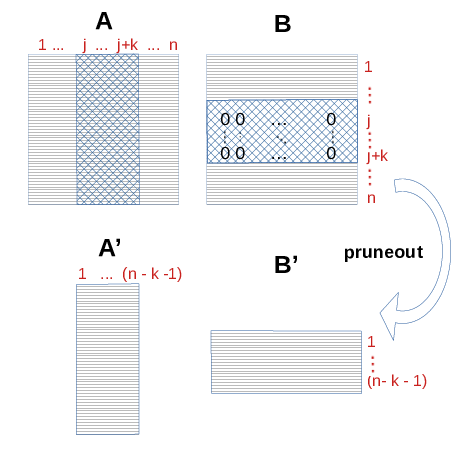

The example above is trivial but when a Faust contains many factors including very sparse matrices, the benefit can be quite significant.
The reason why is that ``pruneout`` repeats the removal operation iteratively until there is no zero column/row eligible to this operation anymore. 

Note that of course the resulting Faust gives the same full matrix (i.e. ``Faust.toarray`` must give the same result after a ``Faust.pruneout``).

In the next section of code we show with a figure how a sliced DFT Faust can benefit of ``Faust.pruneout`` in terms of computation time.

In [ ]:
%matplotlib inline
import pyfaust
from timeit import timeit
from numpy.random import rand
from numpy.random import permutation
import numpy
from numpy import median
import matplotlib.pyplot as plt

times_Fsub = []
times_Fpr = []
n_exps = numpy.arange(5,15)
N = 3


for n_exp in n_exps:
    n = 2**n_exp
    F = pyfaust.dft(n)
    k = 10

    I = permutation(n)[:k]
    I.sort()

    I = list(I)

    Fsubset = F[:,I]
    Fpruned = Fsubset.pruneout()
    x = rand(n)
    xsubset = x[I]
    time = median(timeit(lambda: Fsubset@xsubset, number=N))
    times_Fsub += [time]
    time = median(timeit(lambda: Fpruned@xsubset, number=N))
    times_Fpr += [time]

plt.rc("font", family="serif", size=18)
plt.semilogy(n_exps, times_Fsub, marker='+', label="Fsubset*xsubset")
plt.semilogy(n_exps, times_Fpr, marker='o', label="Fpruned*xsubset")
plt.grid(True)
plt.legend()
plt.xlabel("n_exps")
plt.ylabel("time (s)")
plt.tight_layout()
plt.show()


``Faust.pruneout`` is referenced [here](https://faustgrp.gitlabpages.inria.fr/faust/last-doc/html/classpyfaust_1_1Faust.html#a2a2940af5acbf0531affd10cf03076f1) in the API documentation.

**Note**: this notebook was executed using the following pyfaust version:

In [ ]:
import pyfaust
pyfaust.version()